In [0]:
#Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

import numpy as np
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

1.14.0


In [0]:
#Loading dataset and splitting. Using MNIST dataset

(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

#reshape to specify they are a single channel
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [0]:
#Pre-Process data by scaling pixel values to a rangeof 0 to 1. Divide values by 255
#Images are a 28X28 NPArray with pixel values 0-255, & labels of an array of integers
#ranigng from 0-9

#Process both training and test sets in the same way
def preprocess_images(imgs):
    sample_img = imgs if len(imgs.shape) == 2 else imgs[0]
    assert sample_img.shape in [(28,28,1), (28,28)], sample_img.shape 
    #Above line: assuring images are 28x28 with single channel (grayscale)
    
    return imgs / 255.0
 

In [0]:
train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

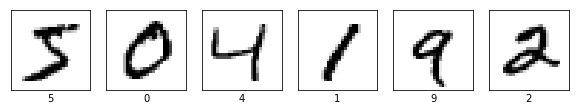

In [0]:
#Verifying data is in correct format in order to assure accurate feeding to model
plt.figure(figsize=(10,2))

for i in range(6):
    #Display first six images
    plt.subplot(1,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

In [0]:
#Building Model

model = keras.Sequential()

#32 convolution filters used, each of size 3x3
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
#Another 62 convolution filers used, same size
model.add(Conv2D(64, (3,3), activation='relu'))
#Choose best features thru pooling
model.add(MaxPooling2D(pool_size=(2,2)))
#Turn neurons on and off at random. Improves convergence
model.add(Dropout(0.25))
#Flatten as there are too many dimension and we only want the calssification output
model.add(Flatten())
#Fully connect all layers to get all relevant data
model.add(Dense(128, activation='relu'))
#Add in another dropout for reason explained above
model.add(Dropout(0.5))
#Now, output a softmax in order to condense the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

W0811 19:06:57.684547 139744925734784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
#Compile model. Add Loss Function: Measures accuracy during training. Goal is to minimize.
#Optimizer: How model is updated based on loss function accuracy
#Metrics: Used to monitor training and testing. "Accuracy" is % of images correctly classified

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#Fit model to train and test data using an 5 epochs.
clf = model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 9s 155us/sample - loss: 0.1913 - acc: 0.9408
Epoch 2/5
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0818 - acc: 0.9758
Epoch 3/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0628 - acc: 0.9808
Epoch 4/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0511 - acc: 0.9841
Epoch 5/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.0445 - acc: 0.9866


In [0]:
#Compare model performance to test data

print(test_images.shape)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test Acc.:', test_acc )

(10000, 28, 28, 1)
10000/10000 [==============================] - 1s 78us/sample - loss: 0.0273 - acc: 0.9922
Test Acc.: 0.9922


Accuracy on test set can be worse than train set, due to overfitting of the training set. 

In this case our testing accuracy is better than the training accuracy due to reglurization from the Dropout layers.

#Animation showing accuracy of model based on other datasets. (Still Wokring on)

Courtesy of Lex Fridman and the MIT DeepLearning Basics Repository.

In [0]:
this_repo_url = 'https://github.com/lexfridman/mit-deep-learning/raw/master/'
this_tutorial_url = this_repo_url + 'tutorial_deep_learning_basics'

mnist_dream_path = 'images/mnist_dream.mp4'
mnist_prediction_path = 'images/mnist_dream_predicted.mp4'

# download the video if running in Colab
if not os.path.isfile(mnist_dream_path): 
    print('downloading the sample video...')
    vid_url = this_tutorial_url + '/' + mnist_dream_path
    
    mnist_dream_path = urllib.request.urlretrieve(vid_url)[0]
                                                                                                  
def cv2_imshow(img):
    ret = cv2.imencode('.png', img)[1].tobytes() 
    img_ip = IPython.display.Image(data=ret)
    IPython.display.display(img_ip)

cap = cv2.VideoCapture(mnist_dream_path) 
vw = None
frame = -1 # counter for debugging (mostly), 0-indexed

# go through all the frames and run our classifier on the high res MNIST images as they morph from number to number
while True: # should 481 frames
    frame += 1
    ret, img = cap.read()
    if not ret: break
               
    assert img.shape[0] == img.shape[1] # should be a square
    if img.shape[0] != 720:
        img = cv2.resize(img, (720, 720))
       
    #preprocess the image for prediction
    img_proc = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_proc = cv2.resize(img_proc, (28, 28))
    img_proc = preprocess_images(img_proc)
    img_proc = 1 - img_proc # inverse since training dataset is white text with black background

    net_in = np.expand_dims(img_proc, axis=0) # expand dimension to specify batch size of 1
    net_in = np.expand_dims(net_in, axis=3) # expand dimension to specify number of channels
    
    preds = model.predict(net_in)[0]
    guess = np.argmax(preds)
    perc = np.rint(preds * 100).astype(int)
    
    img = 255 - img
    pad_color = 0
    img = np.pad(img, ((0,0), (0,1280-720), (0,0)), mode='constant', constant_values=(pad_color))  
    
    line_type = cv2.LINE_AA
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.3        
    thickness = 2
    x, y = 740, 60
    color = (255, 255, 255)
    
    text = "Neural Network Output:"
    cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
    
    text = "Input:"
    cv2.putText(img, text=text, org=(30, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)   
        
    y = 130
    for i, p in enumerate(perc):
        if i == guess: color = (255, 218, 158)
        else: color = (100, 100, 100)
            
        rect_width = 0
        if p > 0: rect_width = int(p * 3.3)
        
        rect_start = 180
        cv2.rectangle(img, (x+rect_start, y-5), (x+rect_start+rect_width, y-20), color, -1)

        text = '{}: {:>3}%'.format(i, int(p))
        cv2.putText(img, text=text, org=(x, y), fontScale=font_scale, fontFace=font_face, thickness=thickness,
                    color=color, lineType=line_type)
        y += 60
    
    # if you don't want to save the output as a video, set this to False
    save_video = True
    
    if save_video:
        if vw is None:
            codec = cv2.VideoWriter_fourcc(*'DIVX')
            vid_width_height = img.shape[1], img.shape[0]
            vw = cv2.VideoWriter(mnist_prediction_path, codec, 30, vid_width_height)
        # 15 fps above doesn't work robustly so we right frame twice at 30 fps
        vw.write(img)
        vw.write(img)
    
    # scale down image for display
    img_disp = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
    cv2_imshow(img_disp)
    IPython.display.clear_output(wait=True)
        
cap.release()
if vw is not None:
    vw.release()